
# BCT Winter 2012
# November 4, 2020
# STATE-SPACE MODELS AND KALMAN FILTER - EXAMPLE - Factor Model




#### HOUSEKEEPING ####


In [1]:
rm(list = ls())
options(repr.plot.width = 10, repr.plot.height = 4)

#### KALMAN FILTER FUNCTION ####

In [2]:
kalFilter <- function(dataIn, statesIn, HmatIn, RRin){

# call data 
dataKal = as.matrix(dataIn)
TT      = dim(dataIn)[1]
KK      = dim(statesIn)[2]

# parameter
QQ = diag(KK)
RR = diag(dim(dataH)[2])*RRin
HH = HmatIn

# initial conditions for states
X0 = statesIn[1,]  # initial state value
P0 = 10*QQ         # initial variance of states set rather high

# allocate matrices
statesF0 = matrix(NA,nrow = TT, ncol = KK)
statesF1 = matrix(NA,nrow = TT, ncol = KK)
stVarsF0 = array(NA,dim = c(TT,KK,KK))
stVarsF1 = array(NA,dim = c(TT,KK,KK))
loglik   = 0
  
# go step-by-step through all periods and filter states:
for (tt in 1:TT){
  
  # predict
  X1pred = X0           # state prediction - random walk here
  P1pred = P0 + QQ      # variance prediction
  YYpred = HH%*%X1pred  # observed values prediction
  
  statesF0[tt,]  = X1pred
  stVarsF0[tt,,] = P1pred
  
  # calculate error of prediction and is variance
  YYerror = dataKal[tt,] - YYpred     # error
  YYerror[is.na(dataKal[tt,])] = 0
  obsVAR = HH%*%P1pred%*%t(HH) + RR       # predicted variance of observations
  
  # get loglik
  if (rcond(obsVAR) > 1e-15){
    loglik = loglik - log(det(obsVAR)) / 2 - t(YYerror) %*% solve(obsVAR) %*% YYerror / 2
    endLoop = F
  }else{ # avoid singularity
    loglik = loglik - 1e50
    endLoop = T
  }
  if (endLoop){break} 
  # updating
  KG     = P1pred%*%t(HH)%*%solve(obsVAR) # Kalman Gain used to update states by error
  X1     = X1pred + KG%*%YYerror          # predicted stated updated by a part of the error
  P1     = P1pred - KG%*%HH%*%P1pred      # predicted state variance updated by the KG
  
  # saving results
  statesF1[tt,]  = X1
  stVarsF1[tt,,] = P1
  
  # going into the next loop
  X0 = X1
  P0 = P1
}

# save # 
kalOut = list(llk = loglik, states = statesF1)
return(kalOut)

}

#### DATA ####

In [3]:
# Load data #
library(readxl)
dataF  <- read_excel("dataFactorModel.xlsx")
dataH <- na.omit(dataF)
dateF <- dataF$date
dateH <- dataH$date
dataF <- dataF[,-1]
dataH <- dataH[,-1]

In [4]:
# set parameters
TTF <- dim(dataF)[1]
TTH <- dim(dataH)[1]

Warning message:
"Removed 378 rows containing missing values (geom_path)."

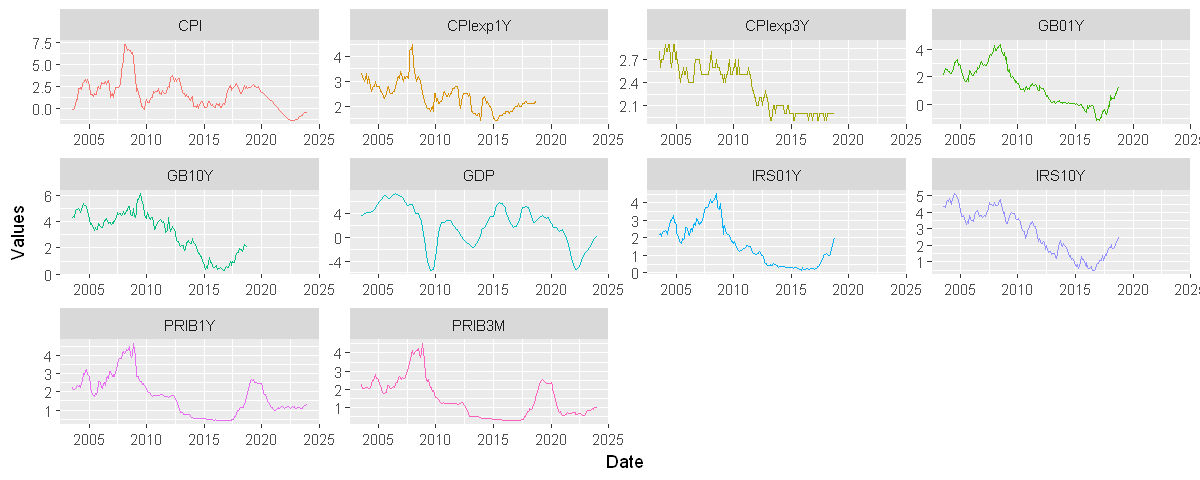

In [5]:
# Prepare ggplot #
library(ggplot2)

data.plot = data.frame(Date        = rep(dateF,length(colnames(dataF))),
                                    Category = rep(t(colnames(dataF)), each=length(dateF)),
                                    Values     = as.vector(as.matrix(dataF)))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                                                 geom_line(aes(color=Category)) + 
                                          facet_wrap(~ Category, scales='free') + 
                                                      theme(legend.position="none")

#### INITIAL VALUES ON HISTORIC DATA ####

In [40]:
# Run PCA # - Principal Components Analysis
#Performs a principal components analysis on the given data matrix and returns the results as an object of class prcomp.
pca.out = prcomp(dataH, center = F, scale. = F) # usually should be centered and scales, not our case
print(cumsum(pca.out$sdev)/sum(pca.out$sdev)*100)
names(pca.out )
#pca.out

 [1]  53.34980  73.45470  82.86748  91.09089  94.31286  96.07986  97.72113
 [8]  98.82817  99.51975 100.00000


[1] "sdev"     "rotation" "center"   "scale"    "x"

In [7]:
# Use first K components and get fitted values
K = 4
pca.states = pca.out$x[,1:K]
pca.loadgs = pca.out$rotation[,1:K]
pca.fitted = pca.states %*% t(pca.loadgs)

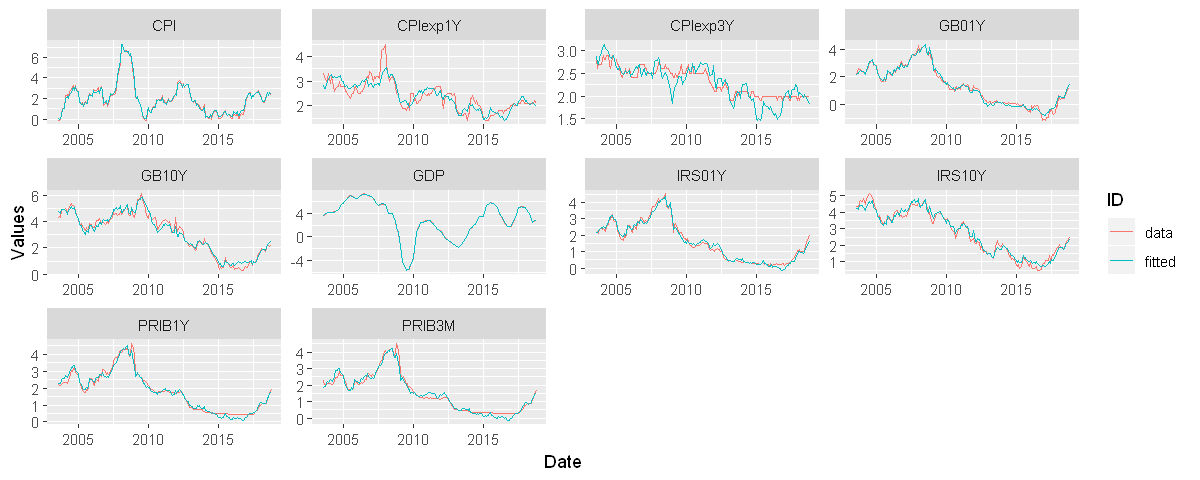

In [8]:
# Plot the fit
data.plotData = data.frame(Date     = rep(dateH,length(colnames(dataF))),
                       Category = rep(t(colnames(dataH)), each=length(dateH)),
                       Values   = as.vector(as.matrix(dataH)))

data.plotData$ID = "data"
data.plotPCA = data.frame(Date     = rep(dateH,length(colnames(dataF))),
                       Category = rep(t(colnames(dataH)), each=length(dateH)),
                       Values   = as.vector(as.matrix(pca.fitted)))

data.plotPCA$ID = "fitted"
data.plot = rbind(data.plotData,data.plotPCA) 
ggplot(data=data.plot,aes(x=Date, y=Values)) +
  geom_line(aes(colour=ID)) + 
  facet_wrap(~ Category, scales='free')

In [9]:
# Save loadings as initial value of Hmat
Hmat0 = pca.loadgs

In [10]:
# Save observed variances as initial values of RR and QQ
pca.resid = as.matrix(dataH - pca.fitted)
RR0 = mean(diag(t(pca.resid)%*%pca.resid)) # use the same error variance for all variables!!

In [11]:
# Prepare initial parameter vector
hmat0 = as.vector(Hmat0)
rr0   = log(RR0)
par0  = as.vector(c(hmat0, rr0))

In [12]:
#### RUN INITIAL KALMAN ####
kalOut0 = kalFilter(dataH, pca.states, Hmat0, RR0)
print(kalOut0$llk)

          [,1]
[1,] -1953.507


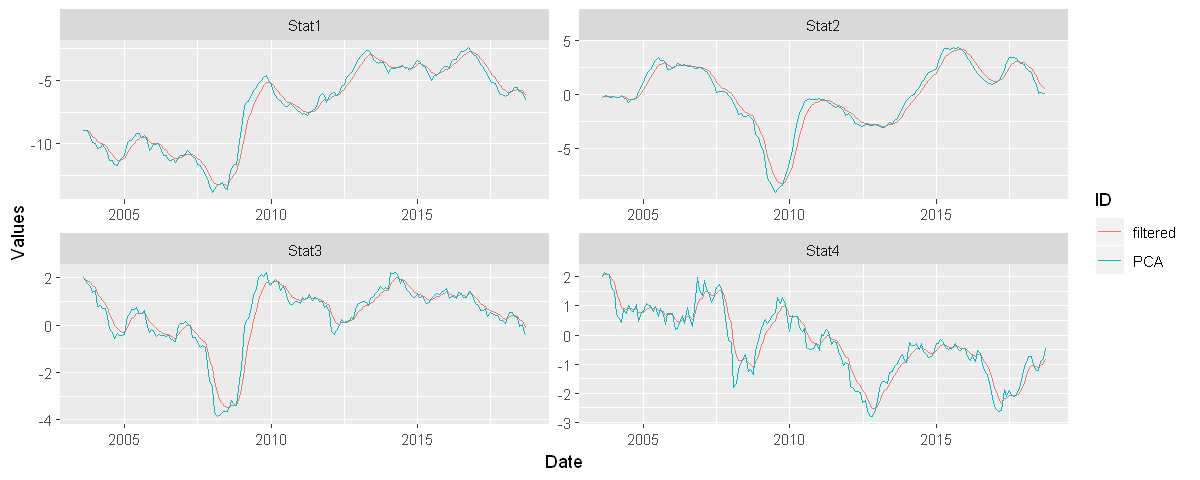

In [13]:
# Plot resulting states
data.plotStates = data.frame(Date     = rep(dateH,K),
                             Category = rep(c('Stat1','Stat2','Stat3','Stat4'),each=TTH),
                             Values   = as.vector(as.matrix(kalOut0$states)))

data.plotStates$ID = "filtered"
data.plotPCA = data.frame(Date     = rep(dateH,K),
                          Category = rep(c('Stat1','Stat2','Stat3','Stat4'), each=TTH),
                          Values   = as.vector(as.matrix(pca.states)))

data.plotPCA$ID = "PCA"
data.plot = rbind(data.plotStates,data.plotPCA) 

ggplot(data=data.plot,aes(x=Date, y=Values)) +
  geom_line(aes(colour=ID)) + 
  facet_wrap(~ Category, scales='free')

In [14]:
# Get fitted values #
kalFit = kalOut0$states %*% t(Hmat0)

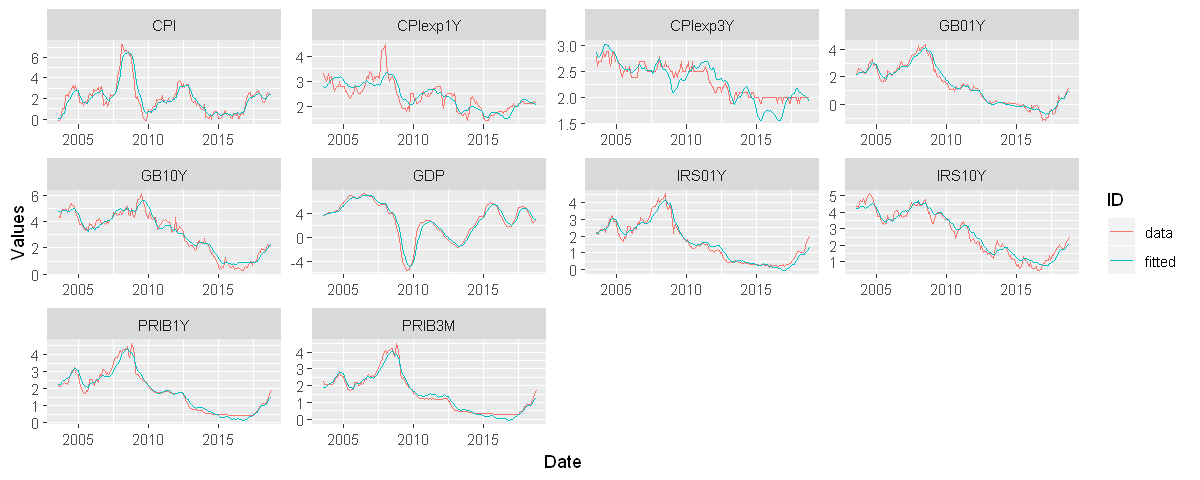

In [15]:
# Plot the fit
data.plotData = data.frame(Date     = rep(dateH,length(colnames(dataF))),
                           Category = rep(t(colnames(dataH)), each=TTH),
                           Values   = as.vector(as.matrix(dataH)))

data.plotData$ID = "data"
data.plotKal = data.frame(Date     = rep(dateH,length(colnames(dataF))),
                          Category = rep(t(colnames(dataH)), each=TTH),
                          Values   = as.vector(kalFit))

data.plotKal$ID = "fitted"
data.plot = rbind(data.plotData,data.plotKal) 

ggplot(data=data.plot,aes(x=Date, y=Values)) +
  geom_line(aes(colour=ID)) + 
  facet_wrap(~ Category, scales='free')

#### OPTIMIZE ####

In [16]:
kalInputH = list(data = dataH, states = pca.states)

In [17]:
# prepare new function to feed parameters and return negloglik
kalOptFun <- function(parameters, kalInput ){
  
  dataInX = kalInput$data
  statesInX = kalInput$states
  KKX = dim(statesInX)[2]
  TTX = dim(dataInX)[2]
  
  HHX = matrix(parameters[1:(KKX*TTX)], ncol = KKX)
  RRX = exp(parameters[KKX*TTX+1])
  loglikX = kalFilter(dataInX, statesInX, HHX, RRX)$llk
  #print(loglikX)
  negLogLik = (-1) * loglikX
  return(negLogLik)
}

In [18]:
print(kalOptFun(par0, kalInputH))

         [,1]
[1,] 1953.507


In [19]:
# optimize - MLE
parOpt <- optim(par0, kalOptFun, gr = NULL, kalInputH, control = list(trace = 3, maxit = 2000), 
                method = "Nelder-Mead")
              # method = c("Nelder-Mead", "BFGS", "CG", "L-BFGS-B", "SANN","Brent")



  Nelder-Mead direct search function minimizer
function value for initial parameters = 1953.506800
  Scaled convergence tolerance is 2.91095e-05
Stepsize computed as 0.195880
BUILD             42 2118.073237 1949.450471
EXTENSION         44 1980.490371 1627.362335
LO-REDUCTION      46 1979.751672 1627.362335
LO-REDUCTION      48 1979.214630 1627.362335
LO-REDUCTION      50 1977.033639 1627.362335
LO-REDUCTION      52 1976.228283 1627.362335
LO-REDUCTION      54 1973.355512 1627.362335
LO-REDUCTION      56 1972.636968 1627.362335
LO-REDUCTION      58 1971.981745 1627.362335
LO-REDUCTION      60 1957.482236 1627.362335
LO-REDUCTION      62 1957.321120 1627.362335
LO-REDUCTION      64 1957.000595 1627.362335
LO-REDUCTION      66 1956.744260 1627.362335
LO-REDUCTION      68 1956.546908 1627.362335
LO-REDUCTION      70 1956.541472 1627.362335
LO-REDUCTION      72 1956.435099 1627.362335
LO-REDUCTION      74 1956.404739 1627.362335
LO-REDUCTION      76 1956.263742 1627.362335
LO-REDUCTION   

In [20]:
parFin = parOpt$par
HHF = matrix(parFin[1:(K*dim(dataH)[2])], ncol = K)
RRF = exp(parFin[K*dim(dataH)[2]+1])

#### RUN FINAL KALMAN ####

In [21]:
kalOut1 = kalFilter(dataH, pca.states, HHF, RRF)
print(kalOut1$llk)

         [,1]
[1,] 717.9397


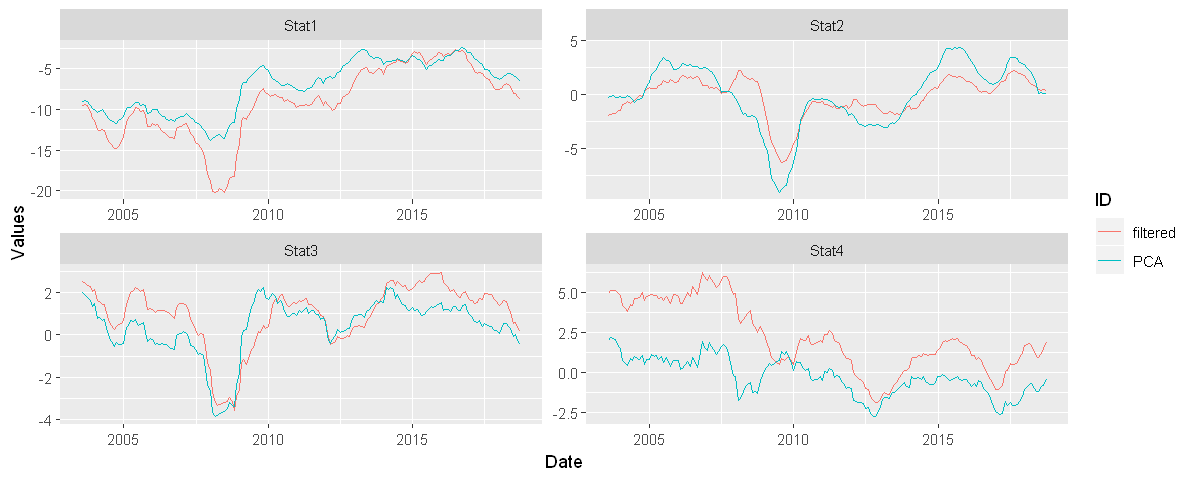

In [22]:
# Plot resulting states
data.plotStates = data.frame(Date     = rep(dateH,K),
                             Category = rep(c('Stat1','Stat2','Stat3','Stat4'),each=TTH),
                             Values   = as.vector(as.matrix(kalOut1$states)))
data.plotStates$ID = "filtered"
data.plotPCA = data.frame(Date     = rep(dateH,K),
                          Category = rep(c('Stat1','Stat2','Stat3','Stat4'), each=TTH),
                          Values   = as.vector(as.matrix(pca.states)))
data.plotPCA$ID = "PCA"
data.plot = rbind(data.plotStates,data.plotPCA) 
ggplot(data=data.plot,aes(x=Date, y=Values)) +
  geom_line(aes(colour=ID)) + 
  facet_wrap(~ Category, scales='free')

In [23]:
# Get fitted values #
kalFit = kalOut1$states %*% t(HHF)

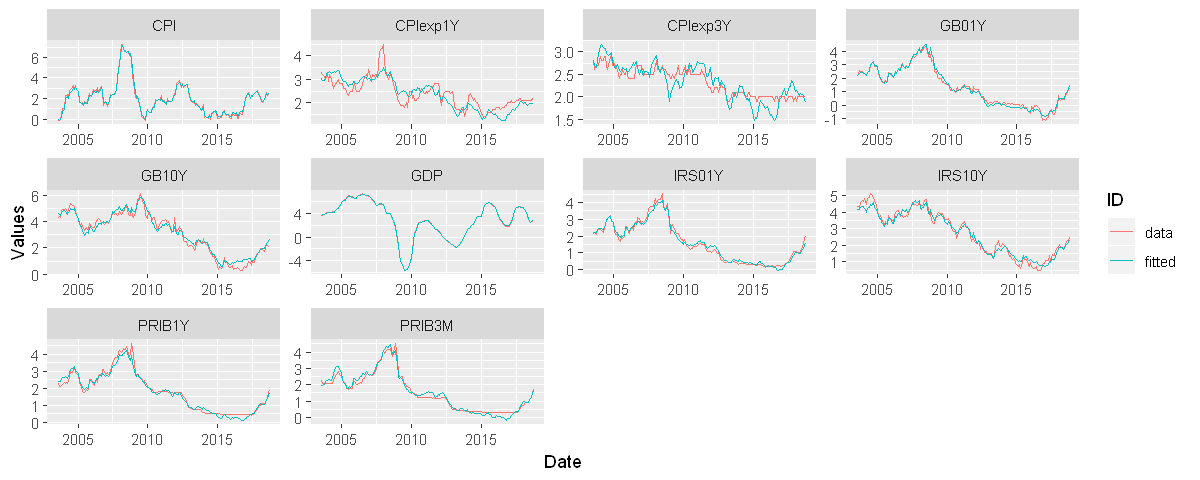

In [24]:
# Plot the fit
data.plotData = data.frame(Date     = rep(dateH,length(colnames(dataH))),
                           Category = rep(t(colnames(dataH)), each=TTH),
                           Values   = as.vector(as.matrix(dataH)))
data.plotData$ID = "data"
data.plotKal = data.frame(Date     = rep(dateH,length(colnames(dataH))),
                          Category = rep(t(colnames(dataH)), each=TTH),
                          Values   = as.vector(kalFit))
data.plotKal$ID = "fitted"
data.plot = rbind(data.plotData,data.plotKal) 
ggplot(data=data.plot,aes(x=Date, y=Values)) +
  geom_line(aes(colour=ID)) + 
  facet_wrap(~ Category, scales='free')

#### USE THE ESTIMATED PARAMETER FOR THE EXTENDED SAMPLE ####

In [25]:
kalOutF = kalFilter(dataF, pca.states, HHF, RRF)
print(kalOutF$llk)

         [,1]
[1,] 1085.622


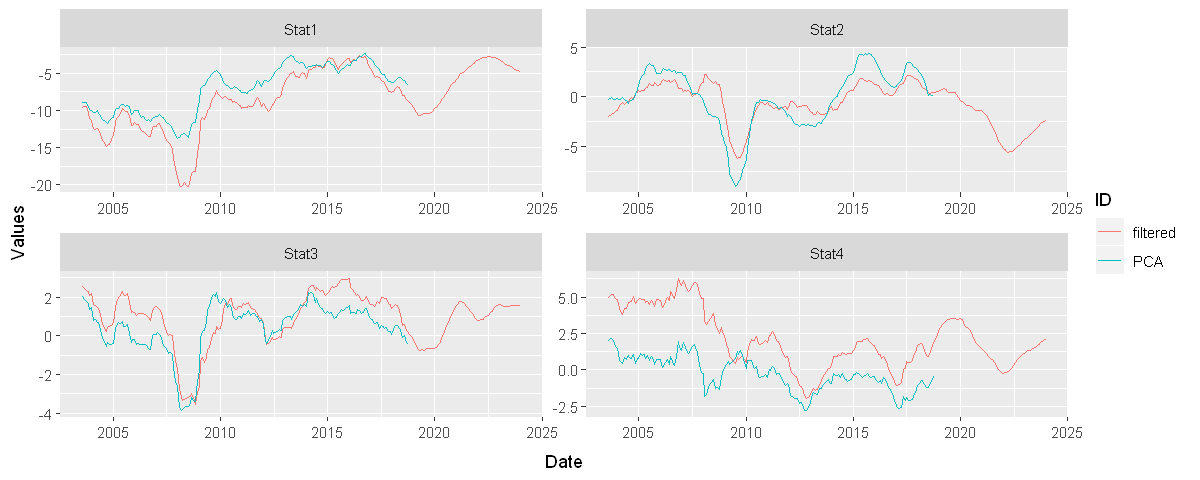

In [26]:
# Plot resulting states
data.plotStates = data.frame(Date     = rep(dateF,K),
                             Category = rep(c('Stat1','Stat2','Stat3','Stat4'),each=TTF),
                             Values   = as.vector(as.matrix(kalOutF$states)))
data.plotStates$ID = "filtered"
data.plotPCA = data.frame(Date     = rep(dateH,K),
                          Category = rep(c('Stat1','Stat2','Stat3','Stat4'), each=TTH),
                          Values   = as.vector(as.matrix(pca.states)))
data.plotPCA$ID = "PCA"
data.plot = rbind(data.plotStates,data.plotPCA) 
ggplot(data=data.plot,aes(x=Date, y=Values)) +
  geom_line(aes(colour=ID)) + 
  facet_wrap(~ Category, scales='free')

In [27]:
# Get fitted values #
kalFit = kalOutF$states %*% t(HHF)

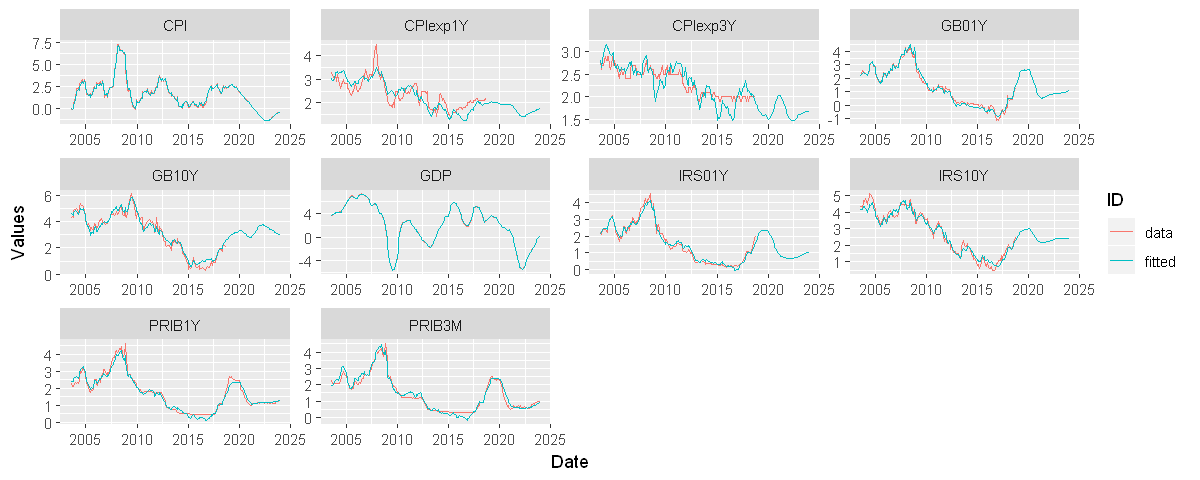

In [28]:
# Plot the fit
data.plotData = data.frame(Date     = rep(dateF,length(colnames(dataF))),
                           Category = rep(t(colnames(dataF)), each=TTF),
                           Values   = as.vector(as.matrix(dataF)))
data.plotData$ID = "data"
data.plotKal = data.frame(Date     = rep(dateF,length(colnames(dataF))),
                          Category = rep(t(colnames(dataF)), each=TTF),
                          Values   = as.vector(kalFit))
data.plotKal$ID = "fitted"
data.plot = rbind(data.plotData,data.plotKal) 
ggplot(data=data.plot,aes(x=Date, y=Values)) +
  geom_line(aes(colour=ID)) + 
  facet_wrap(~ Category, scales='free')